<a href="https://colab.research.google.com/github/lovekittynine/Annotated-DDPM/blob/master/stable_diffusion_play.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# stable diffusion model 试玩

In [1]:
!pip3 install -Uq transformers diffusers accelerate datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00


In [1]:
# stable diffusion pipeline
from diffusers import StableDiffusionPipelineSafe
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import requests
from io import BytesIO
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sd_pipeline = StableDiffusionPipelineSafe.from_pretrained("stabilityai/stable-diffusion-2-1-base").to(device)


# 节省显存
# torch_dtype=torch.float16[效果不太好]
# sd_pipeline.enable_attention_slicing()

generator = torch.Generator(device).manual_seed(94)

prompt = "palette knife painting of an autumn cityscape"
negative_prompt = "oversaturated, blurry, low quality"

pipe_output = sd_pipeline(prompt=prompt, negative_prompt=negative_prompt, height=480, width=640, guidance_scale=8, num_inference_steps=50, generator=generator)
pipe_output.images[0]


/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion_safe/pipeline_stable_diffusion_safe.py:584: UserWarning: Safety checker disabled!
  warnings.warn("Safety checker disabled!")


  0%|          | 0/35 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion_safe/pipeline_stable_diffusion_safe.py:327: FutureWarning: The decode_latents method is deprecated and will be removed in a future version. Please use VaeImageProcessor instead
  warnings.warn(


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

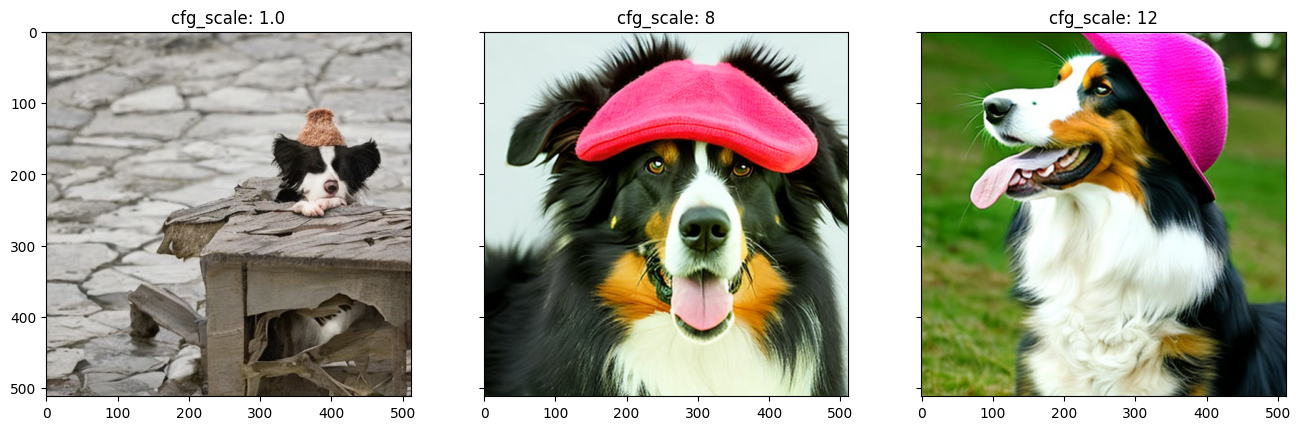

In [6]:
# 探索CFG-scale尺度的影响
cfg_scale = [1.0, 8, 12]
prompt = "A collie with a pink hat"
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)

for i, cfg in enumerate(cfg_scale):
    im = sd_pipeline(prompt=prompt, guidance_scale=cfg, num_inference_steps=35, generator=generator).images[0]
    axes[i].imshow(im)
    axes[i].set_title(f"cfg_scale: {cfg}")

plt.show()



In [12]:
sd_pipeline.scheduler.init_noise_sigma
torch.cuda.empty_cache()

In [2]:
# 探索img2img pipeline
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = Image.open(BytesIO(requests.get(img_url).content)).convert("RGB")
mask_image = Image.open(BytesIO(requests.get(mask_url).content)).convert("RGB")

print(init_image.size)

(512, 512)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

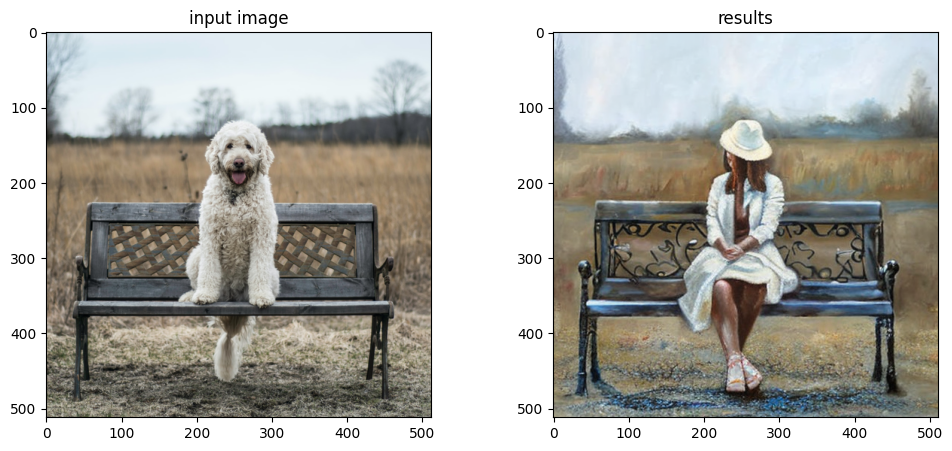

In [3]:
from diffusers import StableDiffusionImg2ImgPipeline
img2img_pipeline = StableDiffusionImg2ImgPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base").to(device)

prompt = "an oil painting of a beautiful women on a bench"
generator = torch.Generator(device).manual_seed(0)

# note output image is pil default
# 这里resize图像会导致vae输出分布发生变化, 生成的图像不理想
# init_image = init_image.resize((128, 128))

output = img2img_pipeline(prompt=prompt, image=init_image, strength=0.6, generator=generator).images[0]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(init_image)
axs[0].set_title("input image")

axs[1].imshow(output)
axs[1].set_title("results")

plt.show()

torch.cuda.empty_cache()

In [9]:
generator.device

device(type='cuda')

torch.Size([2, 77, 1024])


  0%|          | 0/31 [00:00<?, ?it/s]

(1, 512, 512, 3) float32


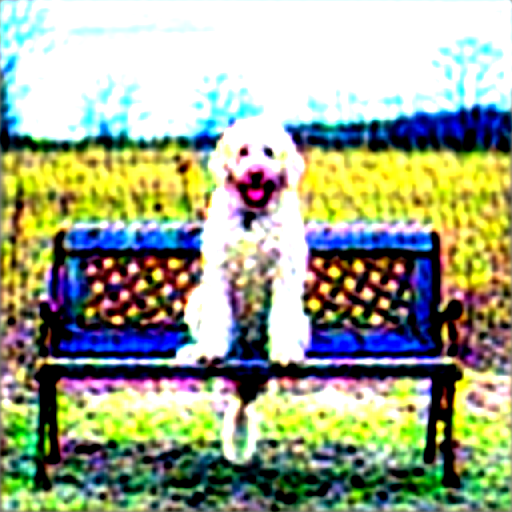

In [22]:
# 手动测试img2img效果, 在stable diffusion基础上实现img2img pipeline
from tqdm.auto import tqdm

with torch.inference_mode():

    image = torch.from_numpy(np.array(init_image, dtype=np.float32) / 255.0).permute([2,0,1]).unsqueeze(0).to(device)
    image = 2.0*image - 1.0

    dist = img2img_pipeline.vae.encode(image).latent_dist
    latent_mean, latent_std = dist.mean, dist.std
    latents = torch.randn((1, 4, 64, 64), device=device) * latent_std + latent_mean

    text_embeddings = img2img_pipeline._encode_prompt(prompt, device, 1, True, "")
    # 不设置无分类器引导时, text embedding shape: 1x77x1024
    # 设置无分类器引导时, text embedding shape: 2x77x1024
    print(text_embeddings.shape)

    noise = torch.randn((1, 4, 64, 64), generator=generator, device=device)

    model_inputs = latents + noise

    # # 单纯从噪声输入[文生图]
    # model_inputs = noise

    img2img_pipeline.scheduler.set_timesteps(num_inference_steps=30)

    for t in tqdm(img2img_pipeline.scheduler.timesteps):
        latent_model_inputs = torch.cat([model_inputs] * 2)
        # print(model_inputs.shape)
        latent_model_inputs = img2img_pipeline.scheduler.scale_model_input(latent_model_inputs)
        # predict noise
        noise_pred = img2img_pipeline.unet(latent_model_inputs, t, encoder_hidden_states=text_embeddings).sample
        # 分别得到无条件噪声预测, 文本条件噪声预测
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        # 预测噪声朝着文本条件方向移动
        noise_pred = noise_pred_uncond + 8.0*(noise_pred_text - noise_pred_uncond)

        # 得到前一步去噪结果
        model_inputs = img2img_pipeline.scheduler.step(noise_pred, t, model_inputs).prev_sample

    # 解码得到预测图片
    img = img2img_pipeline.decode_latents(model_inputs)
    print(img.shape, img.dtype)

img2img_pipeline.numpy_to_pil(img)[0]




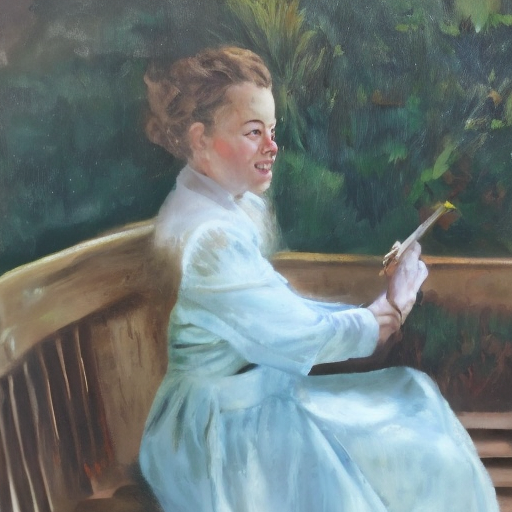

In [17]:
img2img_pipeline.numpy_to_pil(img)[1]

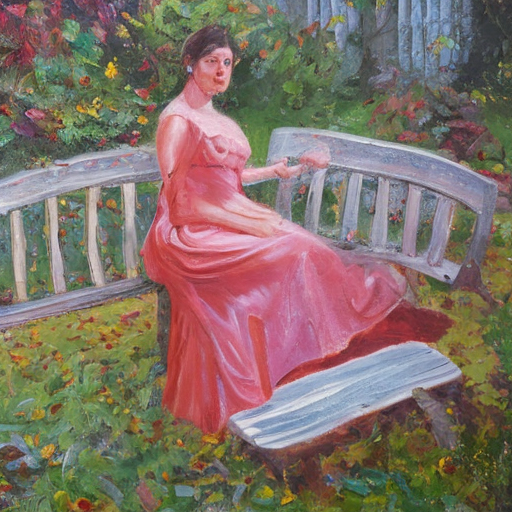

In [18]:
img2img_pipeline.numpy_to_pil(img)[2]

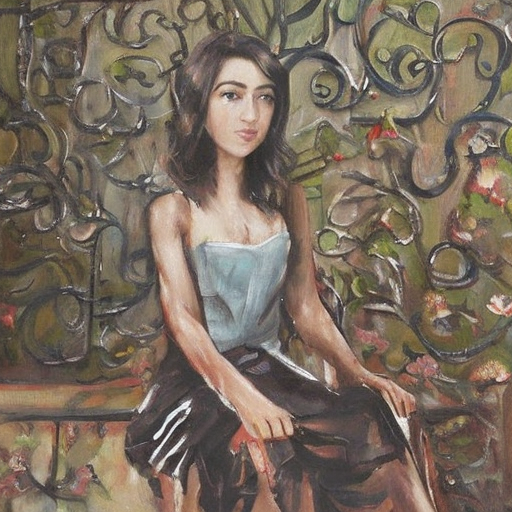

In [19]:
img2img_pipeline.numpy_to_pil(img)[3]